In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import zipfile
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from sklearn.model_selection import train_test_split

In [3]:
def unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Expanding Path
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Single-channel output layer with softmax activation
    output = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=output)

    return model


In [4]:
def load_images_from_zip(zip_image_path, target_size=(128,128)):
    images = []

    # Open the zip file
    with zipfile.ZipFile(zip_image_path, 'r') as zip_file:

        # Iterate over each file in the zip file
        for file_name in zip_file.namelist():

            # Open the file
            with zip_file.open(file_name) as file:

                # Read the image data
                img_data = file.read()

                # Convert the image data to a numpy array
                nparr = np.frombuffer(img_data, np.uint8)

                # Decode the image using OpenCV
                image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

                # Resize the image to the target size
                image = cv2.resize(image, target_size)

                # Append the image to the list of images
                images.append(image)

    # Convert the list of images to a numpy array and return it
    return np.array(images)


In [5]:
image_path = "/content/drive/MyDrive/CameraRGB.zip"
mask_path = "/content/drive/MyDrive/CameraSeg.zip"

# Load images from the image zip file
images = load_images_from_zip(image_path)

# Load images from the mask zip file
masks = load_images_from_zip(mask_path)

# Extract the useful channel data from the masks
masks_image = masks[..., -1]


In [6]:
# Convert masks_image to one-hot encoded masks
masks = [tf.one_hot(i, 13) for i in masks_image]

# Convert the list of one-hot encoded masks to a numpy array
masks = np.array(masks)

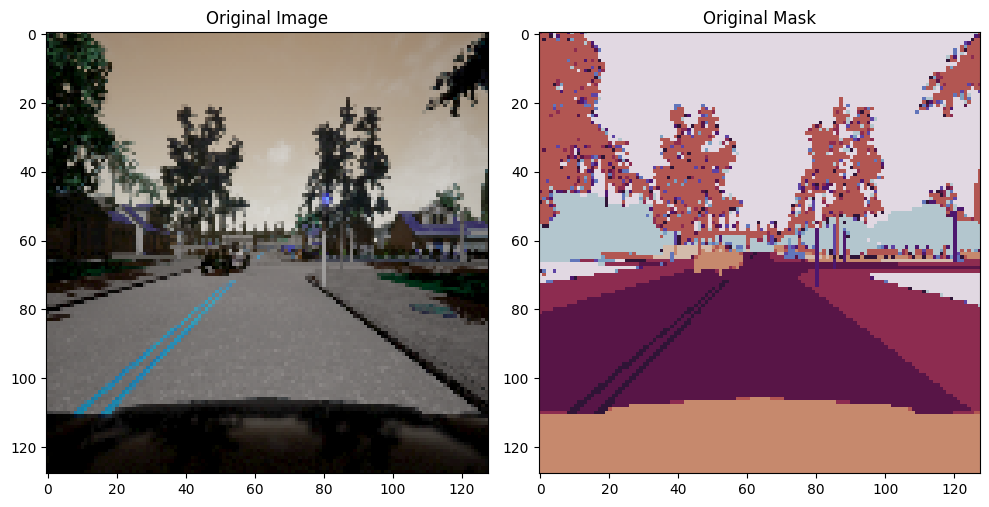

In [7]:
# Showing Random Image and its True Mask.
index = np.random.randint(0,len(images))

# Convert the image array to the appropriate data type
image_array = images[index].astype(np.uint8)

# Define the colormap for pseudocoloring
cmap_name = 'twilight' # Types : 'jet','viridis','magma','inferno','cool','twilight','cubehelix','rainbow'
cmap = plt.get_cmap(cmap_name)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
axs[0].imshow(image_array)
axs[0].axis()  # Turn off axis labels
axs[0].set_title('Original Image')

# Plot the pseudocolored image
pseudocolor_plot = axs[1].imshow(masks_image[index], cmap=cmap)
axs[1].set_title('Original Mask')

# # Add a colorbar to the second subplot
# cbar = plt.colorbar(pseudocolor_plot, ax=axs[1])
# cbar.set_label('Colorbar')

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the figure
plt.show()

# Print the shape
print(images[index].shape,masks_image[index].shape)

In [8]:
# splitting images for test train and validation (train=0.8, test=0.1, val=0.1)
train_data, test_data = train_test_split(images, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# splitting masks data for test train and validation (train=0.8, test=0.1, val=0.1)
train_masks, test_masks = train_test_split(masks, test_size=0.2, random_state=42)
test_masks, val_masks = train_test_split(test_masks, test_size=0.5, random_state=42)

(128, 128, 3) (128, 128)


In [9]:
# Print the shapes of the resulting arrays
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", val_data.shape)

input_shape = (128, 128, 3)  # Input shape (height, width, channels)
num_classes = 13  # number of output classes

model = unet_model(input_shape,num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(x=train_data, y=train_masks, validation_data=(val_data, val_masks), batch_size=16, epochs=20)

Train data shape: (800, 128, 128, 3)
Test data shape: (100, 128, 128, 3)
Validation data shape: (100, 128, 128, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0

In [10]:
# Predict masks for the test data
predicted_masks_images = model.predict(test_data)

# Convert predicted masks to single-channel format
length = len(predicted_masks_images)
predicted_masks = [np.argmax(predicted_masks_images[i], axis=-1) for i in range(length)]

# Convert test masks to single-channel format
test_masks_images = [np.argmax(test_masks[i], axis=-1) for i in range(length)]

4/4 [==============================] - 6s 90ms/step


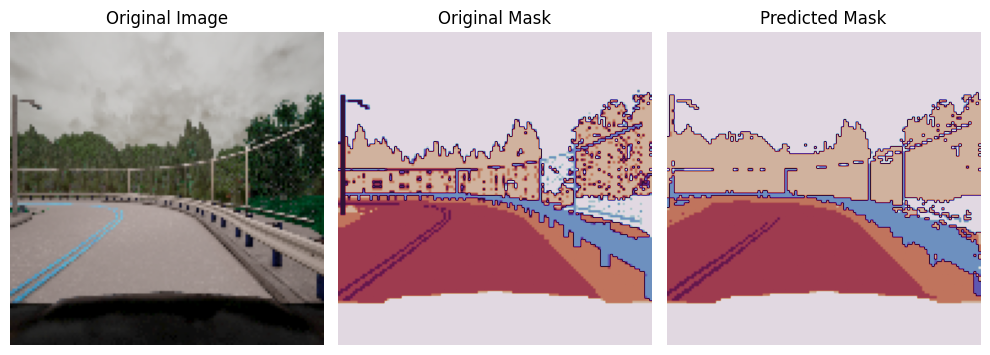

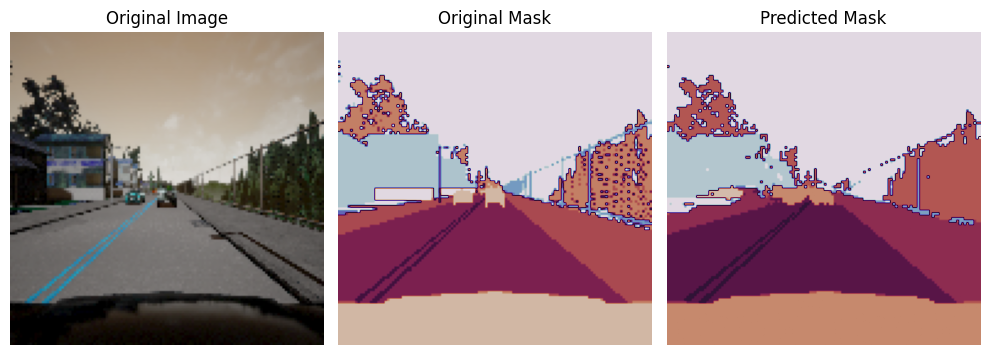

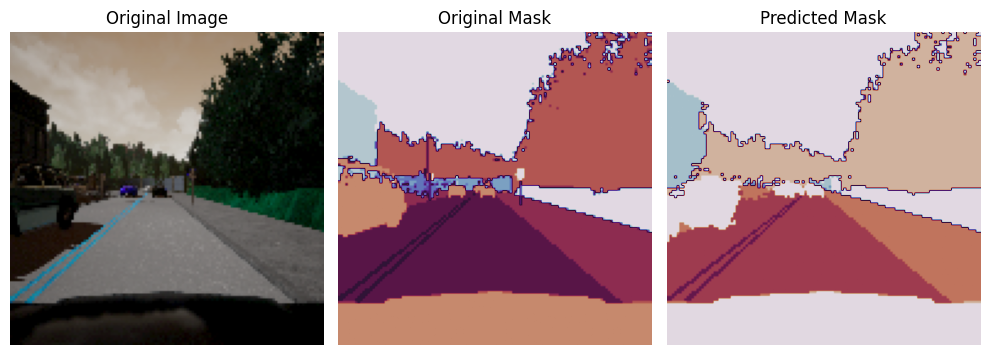

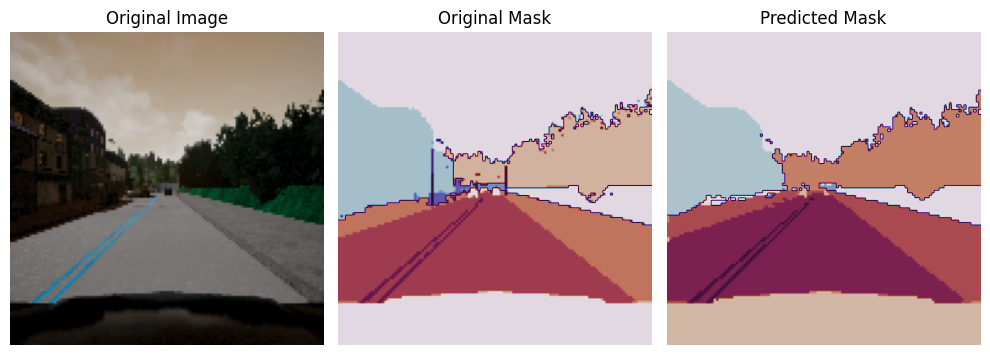

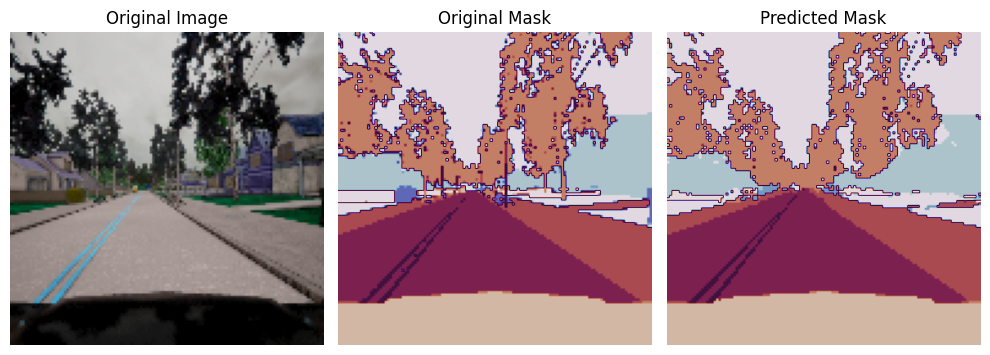

In [13]:
# Select 5 random indices from the test_data
random_indices = random.sample(range(len(test_data)), 5)

# Visualize the selected 5 random images
for i in random_indices:
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    cmap_name = 'twilight'
    cmap = plt.get_cmap(cmap_name)
    # Plot the original image
    axs[0].imshow(test_data[i].astype(np.uint8))
    axs[0].axis('off')  # Turn off axis labels
    axs[0].set_title('Original Image')

    # Plot the original mask
    axs[1].imshow(test_masks_images[i], cmap=cmap)
    axs[1].axis('off')  # Turn off axis labels
    axs[1].set_title('Original Mask')

    # Plot the pseudocolored mask
    axs[2].imshow(predicted_masks[i], cmap=cmap)
    axs[2].axis('off')  # Turn off axis labels
    axs[2].set_title('Predicted Mask')

    # Adjust the spacing between the subplots
    fig.tight_layout()

    # Show the figure
    plt.show()

In [14]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_masks)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 [==============================] - 1s 103ms/step - loss: 0.2962 - accuracy: 0.9180
Test Loss: 0.2961546778678894
Test Accuracy: 0.9179791212081909
